# Semi-supervised vs Supervised — Summary Report 

Notebook này đọc các file metrics/predictions đã sinh ra và tạo báo cáo so sánh:
1) So sánh Accuracy & F1-macro giữa Baseline / Self-training / Co-training.
2) Biểu đồ động lực (pseudo-labels theo vòng lặp).
3) Cảnh báo AQI theo trạm (đếm số lần alert) + ví dụ time series cho 1 trạm.

Gợi ý mini project: chạy nhiều cấu hình (LABEL_MISSING_FRACTION, TAU) -> lưu metrics theo tên khác nhau, rồi đưa list paths vào PARAMETERS để notebook tự tổng hợp.

In [ ]:
BASELINE_METRICS_PATH = "data/processed/metrics.json"

# Semi-supervised artefacts produced by this repo
SELF_METRICS_PATHS = ["data/processed/metrics_self_training.json"]
CO_METRICS_PATHS = ["data/processed/metrics_co_training.json"]

# Optional: station-level storytelling (alerts/predictions)
BASELINE_PRED_PATH = "data/processed/predictions_sample.csv"
SELF_ALERTS_PATH = "data/processed/alerts_self_training_sample.csv"
CO_ALERTS_PATH = "data/processed/alerts_co_training_sample.csv"

# Pick a station to visualize (None -> auto choose top-alert station)
STATION_TO_PLOT = None

# For timeline plots (avoid rendering too many points)
MAX_ROWS_PLOT = 1500

In [ ]:
from pathlib import Path
import json
from typing import Optional, Dict, Any, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# -------- paths (robust for papermill + interactive) --------
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

def _resolve(path_str: str) -> Path:
    return (PROJECT_ROOT / path_str).resolve()

def load_json(path_str: str) -> Optional[Dict[str, Any]]:
    p = _resolve(path_str)
    if not p.exists():
        print("Missing:", p)
        return None
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

def load_csv(path_str: str) -> Optional[pd.DataFrame]:
    p = _resolve(path_str)
    if not p.exists():
        print("Missing:", p)
        return None
    return pd.read_csv(p)

# -------- metrics normalization --------
def normalize_metrics(obj: Optional[Dict[str, Any]], method: str) -> Optional[Dict[str, Any]]:
    """Return a flat dict for summary table.
    - baseline (supervised) often stores metrics as a flat dict.
    - semi-supervised stores {"test_metrics": {...}, "history": [...], "config": {...}}.
    """
    if obj is None:
        return None

    row: Dict[str, Any] = {"method": method}

    if "test_metrics" in obj and isinstance(obj["test_metrics"], dict):
        row.update(obj["test_metrics"])
        # bring tau/cutoff if present
        cfg = obj.get("ct_cfg") or obj.get("st_cfg") or obj.get("config") or {}
        if isinstance(cfg, dict):
            if "tau" in cfg: row["tau"] = cfg["tau"]
            if "cutoff" in cfg: row["cutoff"] = cfg["cutoff"]
        if "cutoff" in obj: row["cutoff"] = obj["cutoff"]
        if "tau" in obj: row["tau"] = obj["tau"]
    else:
        # baseline flat metrics
        if isinstance(obj, dict):
            row.update(obj)

    return row

# -------- load artefacts --------
baseline_obj = load_json(BASELINE_METRICS_PATH)
self_objs = [load_json(p) for p in SELF_METRICS_PATHS]
co_objs = [load_json(p) for p in CO_METRICS_PATHS]

rows: List[Dict[str, Any]] = []
b = normalize_metrics(baseline_obj, "baseline_supervised")
if b is not None:
    rows.append(b)

for obj in self_objs:
    r = normalize_metrics(obj, "self_training")
    if r is not None:
        rows.append(r)

for obj in co_objs:
    r = normalize_metrics(obj, "co_training")
    if r is not None:
        rows.append(r)

if not rows:
    raise FileNotFoundError(
        "No metrics files found. Expected at least one of: "
        f"{BASELINE_METRICS_PATH}, {SELF_METRICS_PATHS}, {CO_METRICS_PATHS}"
    )

dfm = pd.DataFrame(rows)

# Prefer these columns if present
preferred = ["method", "tau", "accuracy", "f1_macro", "precision_macro", "recall_macro", "n_train", "n_test", "cutoff"]
cols = [c for c in preferred if c in dfm.columns] + [c for c in dfm.columns if c not in preferred]
dfm = dfm[cols]

# sort for a clean story
method_order = {"baseline_supervised": 0, "self_training": 1, "co_training": 2}
dfm["_mord"] = dfm["method"].map(method_order).fillna(99)
if "tau" in dfm.columns:
    dfm = dfm.sort_values(["_mord", "tau"], na_position="last")
else:
    dfm = dfm.sort_values(["_mord"])
dfm = dfm.drop(columns=["_mord"])

display(dfm)

,method,tau,accuracy,f1_macro,n_train,n_test,cutoff,report,confusion_matrix,labels,feature_cols,categorical_cols,numeric_cols,config,metrics,history
0,baseline_supervised,NaN,0.665292,0.486761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,self_training,0.7,0.578130,0.505085,0.0,16671.0,2017-01-01 00:00:00,"{'Good': {'precision': 0.7631578947368421, 're...","[[232, 773, 8, 16, 2, 1], [59, 4063, 206, 483,...","[Good, Moderate, Unhealthy_for_Sensitive_Group...","[No, year, month, day, hour, PM10, SO2, NO2, C...","[wd, station]","[No, year, month, day, hour, PM10, SO2, NO2, C...",NaN,NaN,NaN
2,co_training,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'tau': 0.7, 'max_iter': 10, 'max_new_per_iter...","{'accuracy': 0.959379985852442, 'f1_macro': 0....","[{'iter': 1, 'val_f1_A': 0.8661599853349311, '..."


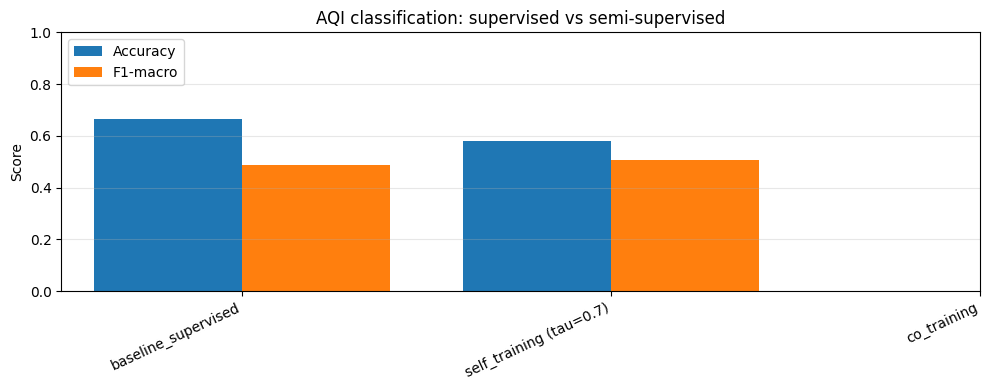

In [ ]:
# Bar chart: Accuracy & F1-macro (if available)
plot_df = dfm.copy()

have_acc = "accuracy" in plot_df.columns
have_f1 = "f1_macro" in plot_df.columns

if not have_acc and not have_f1:
    print("No 'accuracy' or 'f1_macro' columns found in metrics files.")
else:
    plot_df["label"] = plot_df["method"].astype(str)
    if "tau" in plot_df.columns:
        plot_df["label"] = plot_df["label"] + plot_df["tau"].apply(lambda x: "" if pd.isna(x) else f" (tau={x})")

    x = np.arange(len(plot_df))
    fig, ax = plt.subplots(figsize=(10, 4))

    width = 0.4
    if have_acc and have_f1:
        ax.bar(x - width/2, plot_df["accuracy"].values, width=width, label="Accuracy")
        ax.bar(x + width/2, plot_df["f1_macro"].values, width=width, label="F1-macro")
        ax.set_ylim(0, 1.0)
    elif have_acc:
        ax.bar(x, plot_df["accuracy"].values, width=0.6, label="Accuracy")
        ax.set_ylim(0, 1.0)
    else:
        ax.bar(x, plot_df["f1_macro"].values, width=0.6, label="F1-macro")
        ax.set_ylim(0, 1.0)

    ax.set_xticks(x)
    ax.set_xticklabels(plot_df["label"].tolist(), rotation=25, ha="right")
    ax.set_ylabel("Score")
    ax.set_title("AQI classification: supervised vs semi-supervised")
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

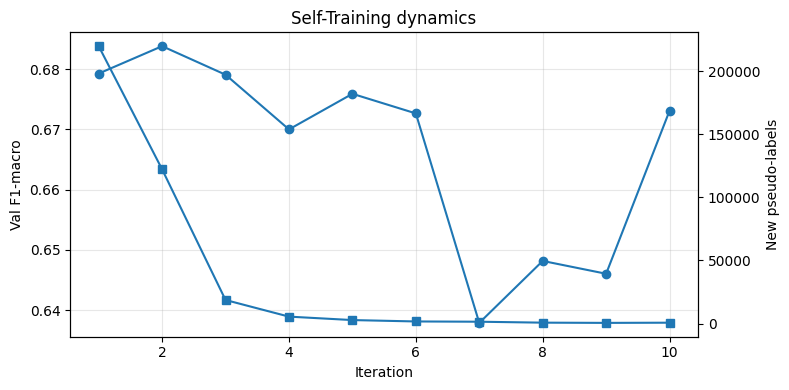

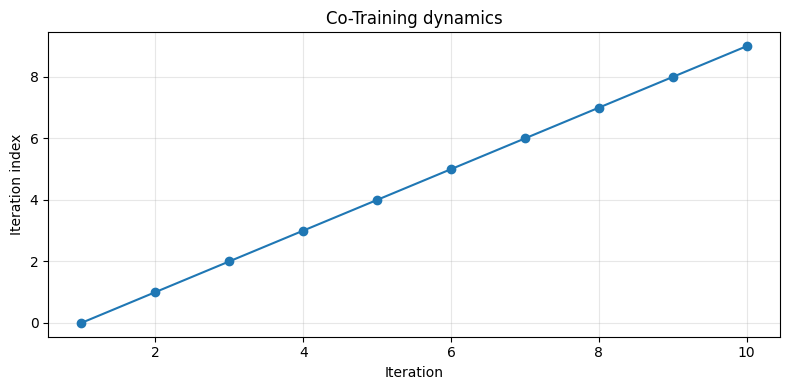

In [ ]:
# Storytelling: pseudo-label dynamics (if history exists)

def load_history(obj: Optional[Dict[str, Any]]) -> Optional[pd.DataFrame]:
    if obj is None:
        return None
    hist = obj.get("history")
    if isinstance(hist, list) and len(hist) > 0:
        return pd.DataFrame(hist)
    return None

h_self = load_history(self_objs[0]) if len(self_objs) else None
h_co = load_history(co_objs[0]) if len(co_objs) else None

def plot_dynamics(h: pd.DataFrame, title: str):
    if h is None or h.empty:
        return
    if "iter" not in h.columns:
        # try fallback
        if "iteration" in h.columns:
            h = h.rename(columns={"iteration": "iter"})
        else:
            print(f"History for {title} has no 'iter' column.")
            return

    fig, ax1 = plt.subplots(figsize=(8, 4))

    if "val_f1_macro" in h.columns:
        ax1.plot(h["iter"], h["val_f1_macro"], marker="o")
        ax1.set_ylabel("Val F1-macro")
    elif "val_accuracy" in h.columns:
        ax1.plot(h["iter"], h["val_accuracy"], marker="o")
        ax1.set_ylabel("Val Accuracy")
    else:
        ax1.plot(h["iter"], np.arange(len(h)), marker="o")
        ax1.set_ylabel("Iteration index")

    ax1.set_xlabel("Iteration")
    ax1.grid(True, alpha=0.3)

    # secondary axis: pseudo-label growth if present
    if "new_pseudo" in h.columns:
        ax2 = ax1.twinx()
        ax2.plot(h["iter"], h["new_pseudo"], marker="s")
        ax2.set_ylabel("New pseudo-labels")

    ax1.set_title(title)
    plt.tight_layout()
    plt.show()

plot_dynamics(h_self, "Self-Training dynamics")
plot_dynamics(h_co, "Co-Training dynamics")


Top alert stations — self_training


,station,n,alert_count,alert_rate
0,Aotizhongxin,1395,721,0.516846
1,Changping,1393,655,0.470208
2,Dingling,1416,604,0.426554
3,Dongsi,796,450,0.565327



Top alert stations — co_training


,station,n,alert_count,alert_rate
11,Wanshouxigong,502,502,1.0
5,Gucheng,478,478,1.0
3,Dongsi,437,437,1.0
9,Tiantan,429,429,1.0
7,Nongzhanguan,415,415,1.0
4,Guanyuan,413,413,1.0
10,Wanliu,413,413,1.0
1,Changping,410,410,1.0
0,Aotizhongxin,409,409,1.0
8,Shunyi,394,394,1.0


C:\Users\buih7\AppData\Local\Temp\ipykernel_23600\2381630455.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top["station"], rotation=25, ha="right")


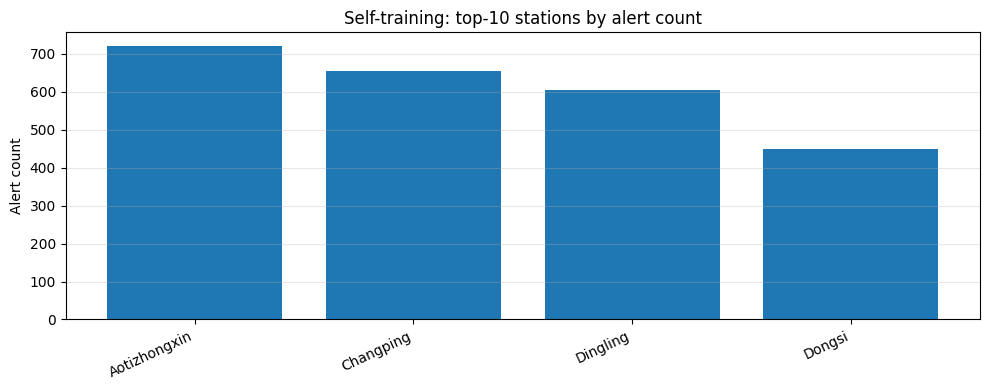

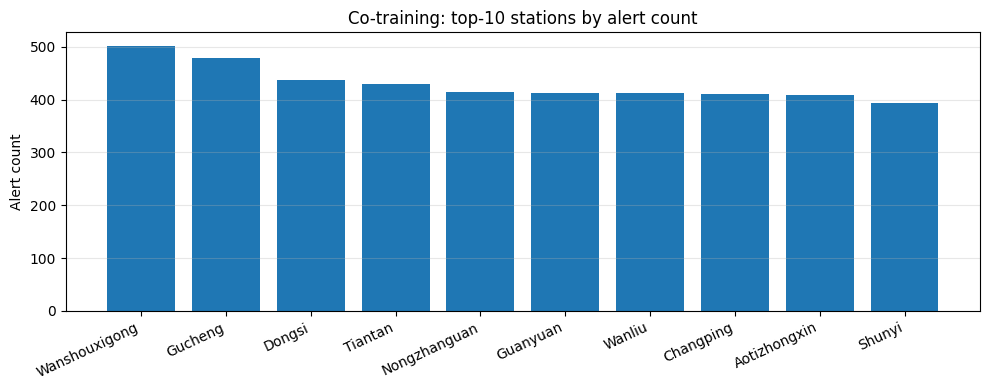

In [ ]:
# Alerts per station (station-level storytelling)

alerts_self = load_csv(SELF_ALERTS_PATH)
alerts_co = load_csv(CO_ALERTS_PATH)

def summarize_alerts(df: Optional[pd.DataFrame], name: str) -> Optional[pd.DataFrame]:
    if df is None:
        return None
    if "station" not in df.columns or "is_alert" not in df.columns:
        print(f"{name}: missing required columns 'station'/'is_alert'. Columns:", df.columns.tolist())
        return None

    d = df.copy()
    d["is_alert"] = pd.to_numeric(d["is_alert"], errors="coerce").fillna(0).astype(int)
    g = (d.groupby("station")
           .agg(n=("is_alert", "size"),
                alert_count=("is_alert", "sum"))
           .reset_index())
    g["alert_rate"] = g["alert_count"] / g["n"].replace(0, np.nan)
    g = g.sort_values(["alert_count", "alert_rate"], ascending=False)
    print(f"\nTop alert stations — {name}")
    display(g.head(10))
    return g

sum_self = summarize_alerts(alerts_self, "self_training")
sum_co = summarize_alerts(alerts_co, "co_training")

def plot_top(g: Optional[pd.DataFrame], title: str):
    if g is None or g.empty:
        return
    top = g.head(10)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(top["station"], top["alert_count"].values)
    ax.set_ylabel("Alert count")
    ax.set_title(title)
    ax.set_xticklabels(top["station"], rotation=25, ha="right")
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_top(sum_self, "Self-training: top-10 stations by alert count")
plot_top(sum_co, "Co-training: top-10 stations by alert count")

Station to plot: Aotizhongxin


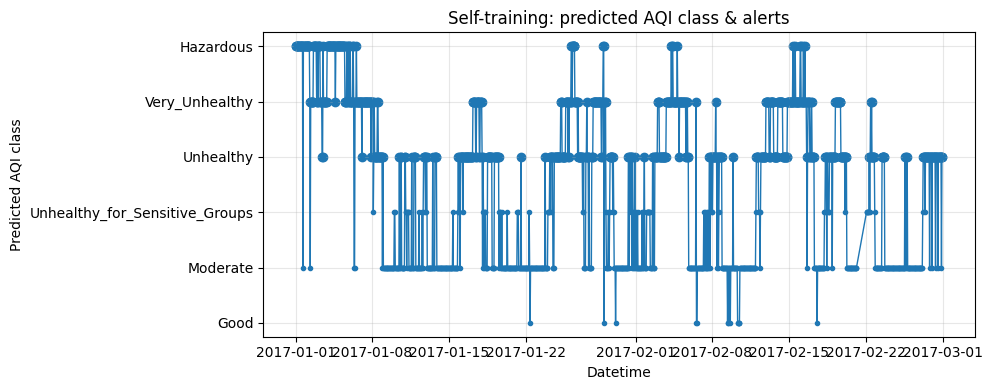

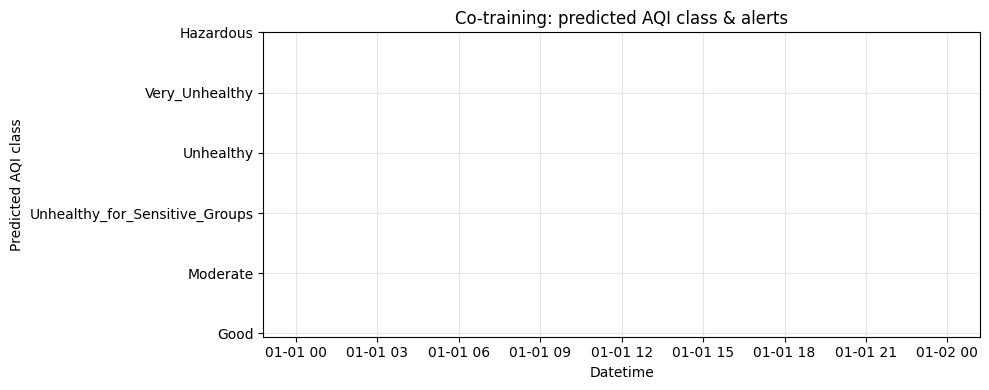

In [ ]:
# Plot station timeline: predicted class + alert markers (self-training first)

def choose_station() -> Optional[str]:
    if STATION_TO_PLOT is not None:
        return str(STATION_TO_PLOT)

    # auto: pick top-alert station from self, then co
    for g in [sum_self, sum_co]:
        if g is not None and not g.empty:
            return str(g.iloc[0]["station"])
    return None

station = choose_station()
print("Station to plot:", station)

def plot_station_timeline(df: Optional[pd.DataFrame], title: str):
    if df is None or station is None:
        return
    if "datetime" not in df.columns:
        print(f"{title}: missing 'datetime' column.")
        return

    d = df[df["station"] == station].copy() if "station" in df.columns else df.copy()
    if d.empty:
        print(f"{title}: no rows for station={station}")
        return

    d["datetime"] = pd.to_datetime(d["datetime"], errors="coerce")
    d = d.dropna(subset=["datetime"]).sort_values("datetime").head(int(MAX_ROWS_PLOT))

    # map class to rank for a clean line plot
    order = ["Good","Moderate","Unhealthy_for_Sensitive_Groups","Unhealthy","Very_Unhealthy","Hazardous"]
    rank = {c:i for i,c in enumerate(order)}

    pred_col = None
    for c in ["y_pred", "pred", "aqi_pred", "aqi_class_pred"]:
        if c in d.columns:
            pred_col = c
            break

    if pred_col is None:
        print(f"{title}: cannot find prediction column (expected y_pred/pred/aqi_pred/aqi_class_pred). Columns:", d.columns.tolist())
        return

    d["pred_rank"] = d[pred_col].map(rank).astype("float64")

    if "is_alert" in d.columns:
        is_alert = pd.to_numeric(d["is_alert"], errors="coerce").fillna(0).astype(int)
        d["alert_y"] = np.where(is_alert.values == 1, d["pred_rank"].values, np.nan)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(d["datetime"], d["pred_rank"], marker=".", linewidth=1)
    if "alert_y" in d.columns:
        ax.scatter(d["datetime"], d["alert_y"])
    ax.set_yticks(list(rank.values()))
    ax.set_yticklabels(order)
    ax.set_xlabel("Datetime")
    ax.set_ylabel("Predicted AQI class")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_station_timeline(alerts_self, "Self-training: predicted AQI class & alerts")
plot_station_timeline(alerts_co, "Co-training: predicted AQI class & alerts")